<a href="https://colab.research.google.com/github/REZAKAZAZI00/Pattern_Recognition/blob/main/pattern_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q datasets nrclex nltk scikit-learn matplotlib seaborn joblib

In [7]:
import math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# NLP & dataset
import nltk
from datasets import load_dataset
from nrclex import NRCLex
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from scipy import stats
import joblib
from tqdm.auto import tqdm

# NLTK resources (once)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
EMOTION_LABELS = [
    "anger", "fear", "anticipation", "trust", "surprise",
    "sadness", "joy", "disgust", "negative", "positive"
]
label2id = {e: i for i, e in enumerate(EMOTION_LABELS)}
id2label = {i: e for e, i in label2id.items()}

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [9]:
def clean_text(text):
    if text is None:
        return ""
    text = str(text).lower().strip()
    if text == "":
        return ""
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

def nrc_features_and_label(text):
    cleaned = clean_text(text)
    if cleaned == "":
        return [0.0]*len(EMOTION_LABELS), None
    emo = NRCLex(cleaned)
    raw = emo.raw_emotion_scores
    counts = [raw.get(e, 0) for e in EMOTION_LABELS]
    total = sum(counts)
    if total == 0:
        return [0.0]*len(EMOTION_LABELS), None
    vec = [c/total for c in counts]
    label = EMOTION_LABELS[int(np.argmax(counts))]
    return vec, label

def add_lexicon_and_label(example):
    title = example.get("questionTitle") or ""
    question = example.get("questionText") or ""
    answer = example.get("answerText") or ""
    full_text = title + " " + question + " " + answer
    vec, label = nrc_features_and_label(full_text)
    example["lexicon_feats"] = vec
    example["emotion_label"] = label if label else "no_emotion"
    return example

print("SECTION 1 — loading dataset and extracting lexicon features (may take time)...")
dataset = load_dataset("nbertagnolli/counsel-chat")
full_ds = dataset["train"]

# Use same split as you had
temp = full_ds.train_test_split(test_size=0.3, seed=42)
train_ds = temp["train"]
temp_2 = temp["test"].train_test_split(test_size=0.5, seed=42)
val_ds = temp_2["train"]
test_ds = temp_2["test"]

# map lexicon (this is the slow part)
train_labeled = train_ds.map(add_lexicon_and_label)
val_labeled   = val_ds.map(add_lexicon_and_label)
test_labeled  = test_ds.map(add_lexicon_and_label)

# filter no_emotion
train_labeled = train_labeled.filter(lambda x: x["emotion_label"] != "no_emotion")
val_labeled   = val_labeled.filter(lambda x: x["emotion_label"] != "no_emotion")
test_labeled  = test_labeled.filter(lambda x: x["emotion_label"] != "no_emotion")

def ds_to_xy(ds):
    X = np.array([x["lexicon_feats"] for x in ds], dtype=float)
    y = np.array([label2id[x["emotion_label"]] for x in ds], dtype=int)
    return X, y

X_train, y_train = ds_to_xy(train_labeled)
X_val, y_val     = ds_to_xy(val_labeled)
X_test, y_test   = ds_to_xy(test_labeled)

print("Preprocessing done. Shapes:")
print(" X_train:", X_train.shape, " X_val:", X_val.shape, " X_test:", X_test.shape)

# Keep ORIGINAL preprocessed data (models will use these, NOT normalized versions)
X_train_orig, X_val_orig, X_test_orig = X_train.copy(), X_val.copy(), X_test.copy()
y_train_orig, y_val_orig, y_test_orig = y_train.copy(), y_val.copy(), y_test.copy()


SECTION 1 — loading dataset and extracting lexicon features (may take time)...


Repo card metadata block was not found. Setting CardData to empty.


Preprocessing done. Shapes:
 X_train: (1938, 10)  X_val: (415, 10)  X_test: (415, 10)


In [10]:
print("\nSECTION 3 — Naive Bayes (on ORIGINAL preprocessed data)")

def compute_confusion_accuracy_and_ci(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = np.trace(cm) / np.sum(cm) if np.sum(cm)>0 else 0.0
    N = len(y_true)
    z = 1.96
    se = math.sqrt((acc * (1 - acc)) / N) if N>0 else 0.0
    ci_low = max(0.0, acc - z * se); ci_high = min(1.0, acc + z * se)
    return cm, acc, (ci_low, ci_high)

def plot_confusion(cm, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTION_LABELS)
    fig, ax = plt.subplots(figsize=(9,7))
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def learning_curve_train_vs_test(model, X_train_s, y_train_s, X_test_s, y_test_s, model_name):
    # incremental training sizes (fractions)
    fracs = np.linspace(0.1, 1.0, 8)
    train_accs, test_accs = [], []
    rng = np.random.RandomState(42)
    n_train = X_train_s.shape[0]
    for frac in fracs:
        size = max(1, int(n_train*frac))
        idx = rng.permutation(n_train)[:size]
        X_sub, y_sub = X_train_s[idx], y_train_s[idx]
        m = clone(model)
        m.fit(X_sub, y_sub)
        train_accs.append(accuracy_score(y_sub, m.predict(X_sub)))
        test_accs.append(accuracy_score(y_test_s, m.predict(X_test_s)))
    # plot
    plt.figure(figsize=(8,6))
    plt.plot(fracs*100, train_accs, marker='o', label='Train Accuracy')
    plt.plot(fracs*100, test_accs, marker='o', label='Test Accuracy')
    plt.xlabel('Training size (%) of original train')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve — {model_name}')
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    diff = np.mean(train_accs[-3:]) - np.mean(test_accs[-3:])
    if diff > 0.07:
        print(f"⚠️ Possible Overfitting detected (diff={diff:.3f})")
    else:
        print(f"✅ No strong overfitting signal (diff={diff:.3f})")
    return train_accs, test_accs

# Fit on train + val (final fit) and evaluate on full (train+val+test)
def run_model_and_report(model, model_name, Xtr, ytr, Xv, yv, Xt, yt):
    print(f"\n>> Running {model_name} (fit on train+val; evaluate on full)")
    X_final_train = np.vstack([Xtr, Xv])
    y_final_train = np.concatenate([ytr, yv])
    model.fit(X_final_train, y_final_train)
    X_all = np.vstack([Xtr, Xv, Xt])
    y_all = np.concatenate([ytr, yv, yt])
    y_pred = model.predict(X_all)
    cm, acc, ci = compute_confusion_accuracy_and_ci(y_all, y_pred)
    print(f"Samples (full) = {len(y_all)}")
    print(f"Accuracy (from CM) = {acc:.4f}")
    print(f"95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    print("\nClassification report:")
    print(classification_report(y_all, y_pred, target_names=EMOTION_LABELS, zero_division=0))
    plot_confusion(cm, f"{model_name} — Confusion Matrix (full)")
    learning_curve_train_vs_test(model, Xtr, ytr, Xt, yt, model_name)
    return {"model_name": model_name, "accuracy": acc, "ci":ci, "model_obj": model}

#nb_model = GaussianNB()
#nb_res = run_model_and_report(nb_model, "GaussianNB", X_train_orig, y_train_orig, X_val_orig, y_val_orig, X_test_orig, y_test_orig)



SECTION 3 — Naive Bayes (on ORIGINAL preprocessed data)



SECTION 4 — Linear SVC (on ORIGINAL preprocessed data)

>> Running LinearSVC (fit on train+val; evaluate on full)
Samples (full) = 2768
Accuracy (from CM) = 0.8255
95% CI = [0.8114, 0.8396]

Classification report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
        fear       1.00      0.01      0.03        68
anticipation       0.98      0.51      0.67       178
       trust       0.97      0.31      0.47       181
    surprise       0.00      0.00      0.00         2
     sadness       1.00      0.20      0.33       112
         joy       0.00      0.00      0.00         3
     disgust       0.00      0.00      0.00         1
    negative       0.75      0.85      0.80       576
    positive       0.84      1.00      0.91      1628

    accuracy                           0.83      2768
   macro avg       0.55      0.29      0.32      2768
weighted avg       0.84      0.83      0.79      2768



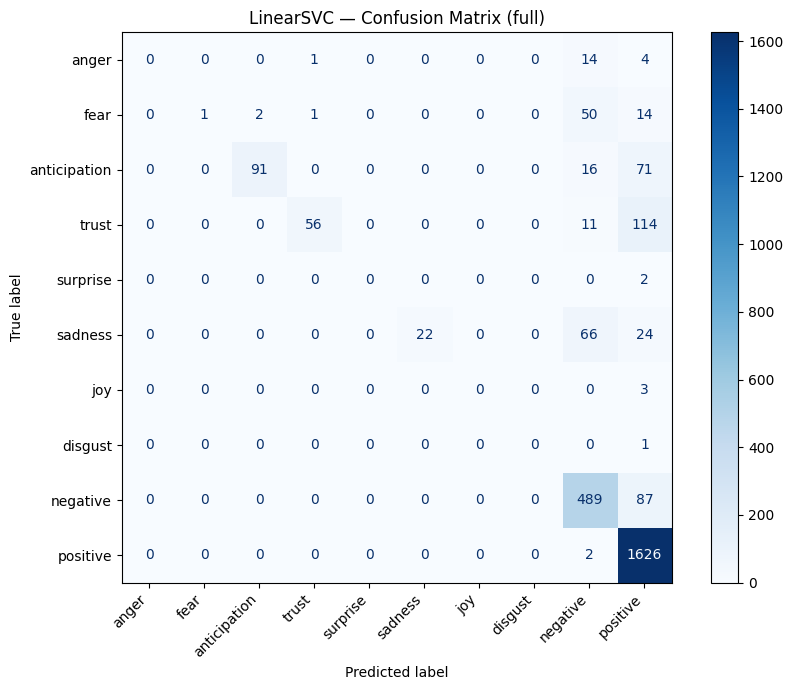

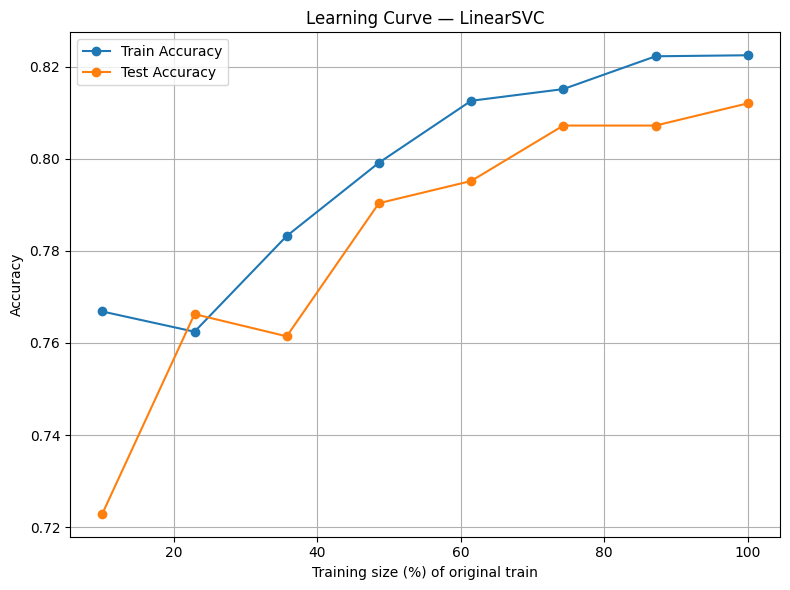

✅ No strong overfitting signal (diff=0.011)

SECTION 5 — SVC (RBF) (on ORIGINAL preprocessed data)

>> Running SVC-RBF (fit on train+val; evaluate on full)
Samples (full) = 2768
Accuracy (from CM) = 0.9483
95% CI = [0.9401, 0.9566]

Classification report:
              precision    recall  f1-score   support

       anger       1.00      0.16      0.27        19
        fear       1.00      0.51      0.68        68
anticipation       0.97      0.92      0.94       178
       trust       0.97      0.82      0.89       181
    surprise       0.00      0.00      0.00         2
     sadness       0.95      0.75      0.84       112
         joy       0.00      0.00      0.00         3
     disgust       0.00      0.00      0.00         1
    negative       0.88      0.99      0.94       576
    positive       0.97      1.00      0.98      1628

    accuracy                           0.95      2768
   macro avg       0.67      0.51      0.55      2768
weighted avg       0.95      0.95      0

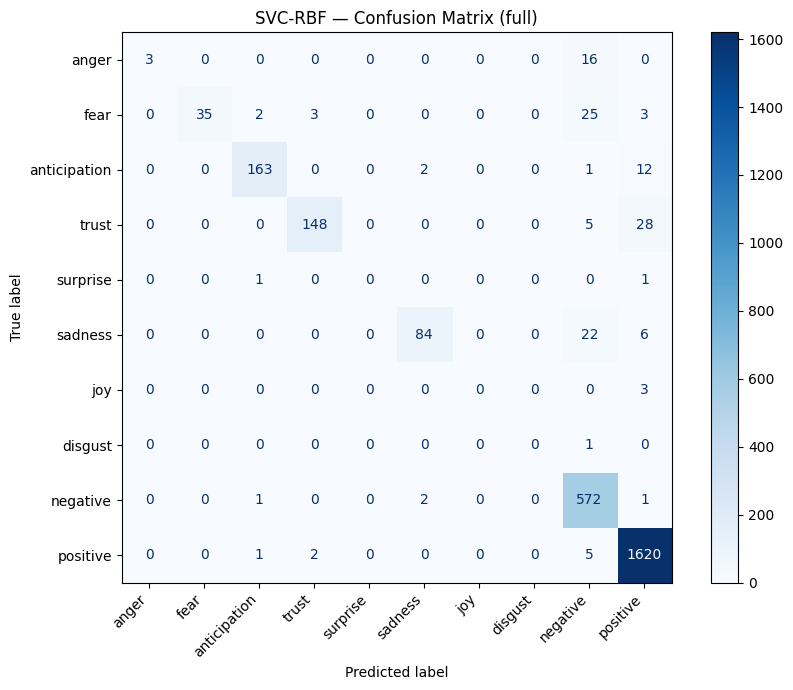

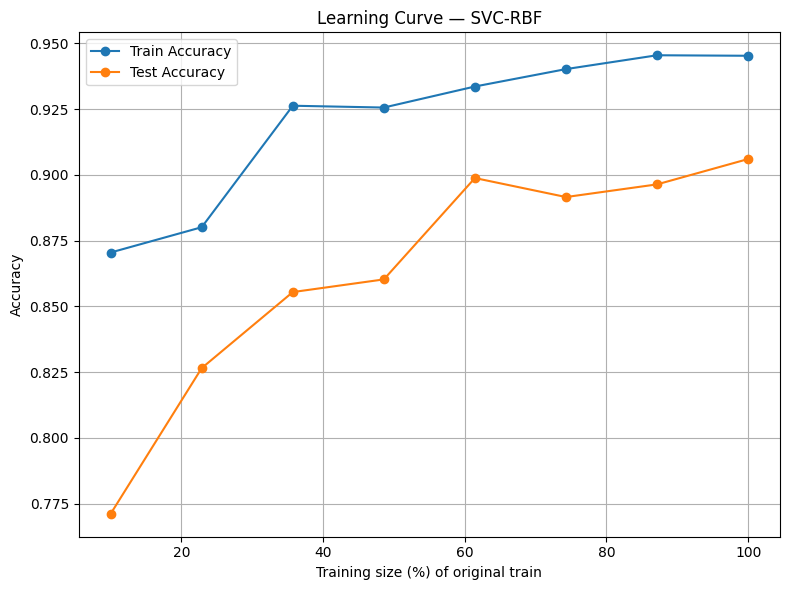

✅ No strong overfitting signal (diff=0.046)


In [12]:

print("\nSECTION 4 — Linear SVC (on ORIGINAL preprocessed data)")
linear_svc = LinearSVC(random_state=42, dual=False, max_iter=20000)
linear_res = run_model_and_report(linear_svc, "LinearSVC", X_train_orig, y_train_orig, X_val_orig, y_val_orig, X_test_orig, y_test_orig)

print("\nSECTION 5 — SVC (RBF) (on ORIGINAL preprocessed data)")
rbf_svc = SVC(kernel='rbf', random_state=42)
rbf_res = run_model_and_report(rbf_svc, "SVC-RBF", X_train_orig, y_train_orig, X_val_orig, y_val_orig, X_test_orig, y_test_orig)
